In [16]:

import matplotlib.pyplot as plt
%matplotlib inline

def confidence_tests(rms_lead, rms_acc):
    conf1 = rms_lead/(max(rms_lead) + rms_acc)
    conf2 = rms_lead/(max(rms_lead/(rms_lead  + rms_acc)) + rms_acc)
    conf3 = rms_lead/((max(rms_lead) + rms_acc) * max(rms_lead/(rms_lead  + rms_acc)))

    return conf1, conf2, conf3

def compute_confidence(rms_lead, rms_acc):
    conf = rms_lead/(max(rms_lead) + rms_acc)
    return conf

    
    

In [31]:
import librosa
import numpy as np
def pitch_confidence(audio_path, sr = 44100, window_len = 2048, hop_len = 128):
    y, sr = librosa.load(audio_path,sr=sr)
    S, phase = librosa.magphase(librosa.stft(y,hop_length=hop_len,n_fft=window_len))
    rms = librosa.feature.rms(S=S).flatten()
    # There is no accompaniment
    acc_rms = np.zeros_like(rms)
    conf = compute_confidence(rms,acc_rms)
    times = librosa.frames_to_time(np.arange(len(conf)), sr=sr, hop_length=hop_len)
    return times, conf

def audio_to_rms(audio, sr = 44100, window_len = 2048, hop_len = 128):
    S, phase = librosa.magphase(librosa.stft(audio,hop_length=hop_len,n_fft=window_len))
    rms = librosa.feature.rms(S=S).flatten()
    return rms

# def ikala_confidence(audio_path, sr = 44100, window_len = 2048, hop_len = 128):
#     audio, sr = librosa.load(audio_path,sr=sr,mono=False)
#     
#     vocal_channel = audio[1, :]
#     rms_vocal = audio_to_rms(vocal_channel)
# 
#     instrumental_channel = audio[0, :]
#     rms_instrumental = audio_to_rms(instrumental_channel)
#     conf = rms_vocal/(rms_vocal + rms_instrumental)
#     times = librosa.frames_to_time(np.arange(len(conf)), sr=sr, hop_length=hop_len)
#     return times, conf

def ikala_confidence(audio_path, sr = 44100, window_len = 2048, hop_len = 128):
    audio, sr = librosa.load(audio_path,sr=sr,mono=False)
    vocal_channel = audio[1, :]
    rms_vocal = audio_to_rms(vocal_channel, window_len = window_len, hop_len = hop_len )

    instrumental_channel = audio[0, :]
    rms_instrumental = audio_to_rms(instrumental_channel, window_len = window_len, hop_len = hop_len)
    conf = compute_confidence(rms_vocal, rms_instrumental)
    times = librosa.frames_to_time(np.arange(len(conf)), sr=sr, hop_length=hop_len)
    return times, conf


# def load_ikala_instrumental_audio(ikalatrack):
#     audio_path = ikalatrack.audio_path
#  
#     S, phase = librosa.magphase(librosa.stft(y,hop_length=hop_len,n_fft=window_len))
#     rms = librosa.feature.rms(S=S).flatten()
#     conf = rms/rms.max()
#     times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=hop_len)
#     return times, conf

def save_confidence(times, conf, filename, out_folder):
    if not os.path.exists(out_folder):
        os.makedirs(out_folder)
    f0_file = get_output_path(filename, out_folder, ".conf.csv")
    f0_data = np.vstack([times, conf]).transpose()
    np.savetxt(f0_file, f0_data, fmt=['%.5f', '%.6f'], delimiter=',')
    print("Writing: " + f0_file)
    
    

In [20]:
import glob,os
def get_audio_track_paths(folder):
    audio_files = glob.glob(os.path.join(folder, "*.wav"))
    return audio_files

def get_audio_track_paths_separated_ikala(folder):
    audio_files_verse = glob.glob(os.path.join(folder, "*verse.wav"))
    audio_files_chorus = glob.glob(os.path.join(folder, "*chorus.wav"))
    all_files = audio_files_verse + audio_files_chorus
    sep = {}
    for file in all_files:
        sep[file] = {}
        acc = file[0:-4] + '_acc_VUIMM.wav'
        lead = file[0:-4] + '_lead_VUIMM.wav'
        sep[file]['acc'] = acc
        sep[file]['lead'] = lead
    return sep

def get_audio_track_paths_separated(gt_folder):
    
    audio_files_verse = glob.glob(os.path.join(folder, "*verse.wav"))
    audio_files_chorus = glob.glob(os.path.join(folder, "*chorus.wav"))
    all_files = audio_files_verse + audio_files_chorus
    sep = {}
    for file in all_files:
        sep[file] = {}
        acc = file[0:-4] + '_acc_VUIMM.wav'
        lead = file[0:-4] + '_lead_VUIMM.wav'
        sep[file]['acc'] = acc
        sep[file]['lead'] = lead
    return sep



def get_output_path(wav_path, output_dir, suffix = '.mel' ):
    """
    return the output path for a given wav file
    """
    new_path = wav_path + suffix
    path = os.path.join(output_dir, os.path.basename(new_path))
    return path




In [21]:
def confidence_separated(separated_audio_paths, sr = 44100, window_len = 2048, hop_len = 128):
    vocal_channel, sr = librosa.load(separated_audio_paths['lead'],sr=sr)
    instrumental_channel, sr = librosa.load(separated_audio_paths['acc'],sr=sr)
    
    rms_vocal = audio_to_rms(vocal_channel, window_len = window_len, hop_len = hop_len)
    rms_instrumental = audio_to_rms(instrumental_channel, window_len = window_len, hop_len = hop_len)
    
    conf = compute_confidence(rms_vocal,rms_instrumental)
    times = librosa.frames_to_time(np.arange(len(conf)), sr=sr, hop_length=hop_len)
    return times, conf


In [22]:

## First tests:
#window_len = 2048
# hop_len = 128

window_len = 2048*2
hop_len = 128*2


sep_file_data =get_audio_track_paths_separated_ikala('/home/juanjoseb/mir_datasets/iKala/mono')
for key,paths in sep_file_data.items():
    print(paths['lead'])
    print(paths['acc'])
    times, conf = confidence_separated(paths, window_len = window_len, hop_len = hop_len)
    out_folder = os.path.join(os.path.dirname(paths['lead']) , 'conf')
    save_confidence(times, conf, paths['lead'], out_folder)

    #times, conf = pitch_confidence(audio_file)
    #out_folder = os.path.join(os.path.dirname(audio_file) , 'conf')
    #save_confidence(times, conf, audio_file, out_folder)
    

/home/juanjoseb/mir_datasets/iKala/mono/54245_verse_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/54245_verse_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/54245_verse_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/21057_chorus_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/21057_chorus_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/21057_chorus_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/71720_chorus_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/71720_chorus_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/71720_chorus_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/45428_verse_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/45428_verse_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/45428_verse_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/90587_verse_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/

Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/54246_chorus_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/45359_verse_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/45359_verse_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/45359_verse_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/31109_chorus_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/31109_chorus_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/31109_chorus_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/54216_verse_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/54216_verse_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/54216_verse_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/45429_verse_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/45429_verse_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/45429_verse_lead_VUIMM.wav.conf.csv
/home/juanjose

Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/54192_verse_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/21076_verse_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/21076_verse_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/21076_verse_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/21083_chorus_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/21083_chorus_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/21083_chorus_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/54233_chorus_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/54233_chorus_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/54233_chorus_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/10164_chorus_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/10164_chorus_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/10164_chorus_lead_VUIMM.wav.conf.csv
/home/jua

Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/21039_verse_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/45391_verse_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/45391_verse_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/45391_verse_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/31143_chorus_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/31143_chorus_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/31143_chorus_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/45361_chorus_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/45361_chorus_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/45361_chorus_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/45378_verse_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/45378_verse_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/45378_verse_lead_VUIMM.wav.conf.csv
/home/juanjo

Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/21086_chorus_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/31113_verse_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/31113_verse_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/31113_verse_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/45386_chorus_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/45386_chorus_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/45386_chorus_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/45398_chorus_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/45398_chorus_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/45398_chorus_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/54183_chorus_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/54183_chorus_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/54183_chorus_lead_VUIMM.wav.conf.csv
/home/ju

Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/66561_chorus_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/54191_verse_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/54191_verse_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/54191_verse_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/10174_verse_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/10174_verse_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/10174_verse_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/31139_chorus_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/31139_chorus_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/31139_chorus_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/45381_verse_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/45381_verse_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/45381_verse_lead_VUIMM.wav.conf.csv
/home/juanjose

Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/31136_verse_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/21033_verse_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/21033_verse_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/21033_verse_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/21068_verse_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/21068_verse_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/21068_verse_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/31101_chorus_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/31101_chorus_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/31101_chorus_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/iKala/mono/21031_verse_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/iKala/mono/21031_verse_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/iKala/mono/conf/21031_verse_lead_VUIMM.wav.conf.csv
/home/juanjoseb

In [25]:
paths = get_audio_track_paths('/home/juanjoseb/mir_datasets/MedleyDB-Pitch/audio')


In [29]:
pitch_paths = get_audio_track_paths('/home/juanjoseb/mir_datasets/MedleyDB-Pitch/audio')

In [32]:
for audio_file in pitch_paths:
    times, conf = pitch_confidence(audio_file, window_len = window_len, hop_len = hop_len)
    out_folder = os.path.join(os.path.dirname(audio_file) , 'conf')
    save_confidence(times, conf, audio_file, out_folder)

Writing: /home/juanjoseb/mir_datasets/MedleyDB-Pitch/audio/conf/MusicDelta_BebopJazz_STEM_04.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/MedleyDB-Pitch/audio/conf/MusicDelta_Beatles_STEM_08.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/MedleyDB-Pitch/audio/conf/HeladoNegro_MitadDelMundo_STEM_08.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/MedleyDB-Pitch/audio/conf/HopAlong_SisterCities_STEM_07.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/MedleyDB-Pitch/audio/conf/MusicDelta_Grunge_STEM_05.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/MedleyDB-Pitch/audio/conf/MusicDelta_Rock_STEM_05.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/MedleyDB-Pitch/audio/conf/Meaxic_YouListen_STEM_01.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/MedleyDB-Pitch/audio/conf/MusicDelta_Country1_STEM_05.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/MedleyDB-Pitch/audio/conf/EthanHein_1930sSynthAndUprightBass_STEM_04.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/Med

Writing: /home/juanjoseb/mir_datasets/MedleyDB-Pitch/audio/conf/MusicDelta_ChineseDrama_STEM_01.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/MedleyDB-Pitch/audio/conf/MusicDelta_Pachelbel_STEM_04.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/MedleyDB-Pitch/audio/conf/SecretMountains_HighHorse_STEM_01.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/MedleyDB-Pitch/audio/conf/AimeeNorwich_Flying_STEM_15.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/MedleyDB-Pitch/audio/conf/MusicDelta_FusionJazz_STEM_05.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/MedleyDB-Pitch/audio/conf/TheDistricts_Vermont_STEM_05.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/MedleyDB-Pitch/audio/conf/FacesOnFilm_WaitingForGa_STEM_03.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/MedleyDB-Pitch/audio/conf/MatthewEntwistle_ImpressionsOfSaturn_STEM_08.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/MedleyDB-Pitch/audio/conf/BigTroubles_Phantom_STEM_04.wav.conf.csv
Writing: /home/juan

In [ ]:
for audio_file in pitch_paths:
    times, conf = pitch_confidence(audio_file, window_len = window_len, hop_len = hop_len)
    out_folder = os.path.join(os.path.dirname(audio_file) , 'conf')
    save_confidence(times, conf, audio_file, out_folder)

In [23]:
ikala_paths = get_audio_track_paths('/home/juanjoseb/mir_datasets/iKala/Wavfile/')
for audio_file in ikala_paths:
    times, conf = ikala_confidence(audio_file,window_len = window_len, hop_len = hop_len)
    out_folder = os.path.join(os.path.dirname(audio_file) , 'conf')
    save_confidence(times, conf, audio_file, out_folder)

Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/45387_verse.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/31136_verse.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/31075_chorus.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/45435_verse.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/31092_chorus.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/31144_verse.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/45409_verse.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/80616_verse.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/21062_verse.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/54216_verse.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/54189_chorus.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/54245_chorus.wav.conf.csv
Writing: /ho

Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/21057_chorus.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/45305_chorus.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/54211_chorus.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/54220_chorus.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/54183_chorus.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/54228_chorus.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/31083_verse.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/45390_verse.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/54205_verse.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/21025_chorus.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/66563_verse.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/21073_chorus.wav.conf.csv
Writing:

Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/31132_verse.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/90586_verse.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/31139_chorus.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/66559_chorus.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/61676_chorus.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/21035_verse.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/21086_chorus.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/45378_chorus.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/21084_verse.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/31114_verse.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/21083_chorus.wav.conf.csv
Writing: /home/juanjoseb/mir_datasets/iKala/Wavfile/conf/31143_chorus.wav.conf.csv
Writing: 

Text(0.5, 1.0, 'Normalised energy')

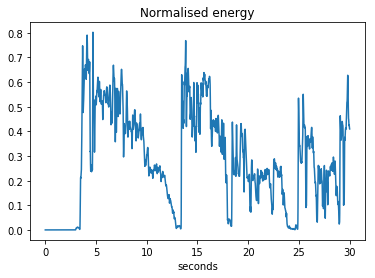

In [24]:
import pylab as plt
plt.plot(times, conf)
plt.xlabel('seconds')
plt.title("Normalised energy")

In [80]:
import os
os.chdir('/home/juanjoseb/code/mirdata/')

In [91]:
#for key, track in orchset_data.items():
#    print(track.audio_path_mono)

    
import mirdata
def get_audio_track_paths_separated_orchset():
    orchset_data = mirdata.orchset.load()
    sep = {}
    for key, track in orchset_data.items():
        file = track.audio_path_mono
        sep[file] = {}
        acc = file[0:-4] + '_acc_VUIMM.wav'
        lead = file[0:-4] + '_lead_VUIMM.wav'
        sep[file]['acc'] = acc
        sep[file]['lead'] = lead
    return sep

sep_orchset_paths = get_audio_track_paths_separated_orchset()

In [94]:
## Confidence for Orchset


def compute_separated_confidence(sep_file_data, window_len = 2048, hop_len = 128):
    for key,paths in sep_file_data.items():
        print(paths['lead'])
        print(paths['acc'])
        times, conf = confidence_separated(paths, window_len = window_len, hop_len = hop_len)
        out_folder = os.path.join(os.path.dirname(paths['lead']) , 'conf')
        save_confidence(times, conf, paths['lead'], out_folder)

compute_separated_confidence(sep_orchset_paths, window_len = window_len, hop_len = hop_len)

    #times, conf = pitch_confidence(audio_file)
    #out_folder = os.path.join(os.path.dirname(audio_file) , 'conf')
    #save_confidence(times, conf, audio_file, out_folder)
    

/home/juanjoseb/mir_datasets/Orchset/audio/mono/Beethoven-S5-II-ex3_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/Orchset/audio/mono/Beethoven-S5-II-ex3_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/Orchset/audio/mono/conf/Beethoven-S5-II-ex3_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/Orchset/audio/mono/Rimski-Korsakov-Scheherazade-Kalender-ex1_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/Orchset/audio/mono/Rimski-Korsakov-Scheherazade-Kalender-ex1_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/Orchset/audio/mono/conf/Rimski-Korsakov-Scheherazade-Kalender-ex1_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/Orchset/audio/mono/Holst-ThePlanets-Jupiter-ex1_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/Orchset/audio/mono/Holst-ThePlanets-Jupiter-ex1_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/Orchset/audio/mono/conf/Holst-ThePlanets-Jupiter-ex1_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/Orchset/audio/mono/Brahms-S3-III-ex2_lead_VUIMM.wav
/home/juanjos

Writing: /home/juanjoseb/mir_datasets/Orchset/audio/mono/conf/Beethoven-S7-II-ex2_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/Orchset/audio/mono/Haydn-S94-Menuet-ex2_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/Orchset/audio/mono/Haydn-S94-Menuet-ex2_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/Orchset/audio/mono/conf/Haydn-S94-Menuet-ex2_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/Orchset/audio/mono/Profofiev-Romeo&Juliet-DanceKnights-ex1_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/Orchset/audio/mono/Profofiev-Romeo&Juliet-DanceKnights-ex1_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/Orchset/audio/mono/conf/Profofiev-Romeo&Juliet-DanceKnights-ex1_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/Orchset/audio/mono/Beethoven-S3-I-ex3_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/Orchset/audio/mono/Beethoven-S3-I-ex3_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/Orchset/audio/mono/conf/Beethoven-S3-I-ex3_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_d

Writing: /home/juanjoseb/mir_datasets/Orchset/audio/mono/conf/Schubert-S8-II-ex2_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/Orchset/audio/mono/Musorgski-Ravel-PicturesExhibition-ex7_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/Orchset/audio/mono/Musorgski-Ravel-PicturesExhibition-ex7_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/Orchset/audio/mono/conf/Musorgski-Ravel-PicturesExhibition-ex7_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/Orchset/audio/mono/Smetana-MaVlast-Vltava-ex1_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/Orchset/audio/mono/Smetana-MaVlast-Vltava-ex1_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/Orchset/audio/mono/conf/Smetana-MaVlast-Vltava-ex1_lead_VUIMM.wav.conf.csv
/home/juanjoseb/mir_datasets/Orchset/audio/mono/Rimski-Korsakov-Scheherazade-YoungPrincePrincess-ex2_lead_VUIMM.wav
/home/juanjoseb/mir_datasets/Orchset/audio/mono/Rimski-Korsakov-Scheherazade-YoungPrincePrincess-ex2_acc_VUIMM.wav
Writing: /home/juanjoseb/mir_datasets/Orchse